# Text Mining using Dimensionality Reduction Methods


This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have seen this week can be readily applied to get a good idea of what our users are expressing.

In [344]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc


# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) (see the lectures, slide 34).

In [174]:
# Be sure to first leave the data here!
imdb_data = pd.read_excel('IMDB_Sample.xlsx')
# print(imdb_data.head())

# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )


# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)
# print('\n')
print(x_train.iloc[340])
# print(y_train)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

print('\n')
print(TfIDF_train[340])
print('\n')
# print(TfIDF_train.shape)


# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()
print(TfIDF_train[2])
# print('\n')
# print(TfIDF_train[2])


Rating "10/10" Master pieceSome years ago, i heard Spielberg comment that he would redo the movie here and there if he had a chance. Well, Mr Spielberg, i guess nothing is perfect, but this movie - together with schindler's List - is your best. Even Oprah acts well in this one !What got me most is the realism of the story and drama. Stuff like this happened and is still happening in the world.'


  (0, 234)	0.2995571399523656
  (0, 228)	0.31845387467961445
  (0, 51)	0.3969415589322562
  (0, 111)	0.1939070474462102
  (0, 0)	0.5576500961578521
  (0, 83)	0.3243705784118214
  (0, 134)	0.2689214200650097
  (0, 192)	0.21692010935334918
  (0, 18)	0.2795123243302363


[0.         0.         0.         0.         0.         0.
 0.         0.         0.44416968 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

We can check the outputs of the first row with the below code.

In [160]:
print(TfIDF_train[1,:])

[0.         0.         0.         0.         0.         0.16565558
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24573797 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.17111284 0.
 0.         0.         0.         0.         0.17934085 0.
 0.18989355 0.         0.20293873 0.         0.         0.
 0.         0.         0.15861506 0.         0.28146216 0.15964171
 0.         0.         0.13397591 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.2143442  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11417021 0.
 0.         0.         0.         0.         0.19858848 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.1750

Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [40]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


In [41]:
TfIDFTransformer.get_feature_names()


['10',
 'absolutely',
 'acting',
 'action',
 'actor',
 'actors',
 'actress',
 'actually',
 'age',
 'amazing',
 'american',
 'art',
 'audience',
 'away',
 'awful',
 'bad',
 'beautiful',
 'believe',
 'best',
 'better',
 'big',
 'bit',
 'black',
 'book',
 'boring',
 'budget',
 'came',
 'camera',
 'cast',
 'character',
 'characters',
 'children',
 'classic',
 'close',
 'come',
 'comedy',
 'comes',
 'completely',
 'couldn',
 'course',
 'day',
 'days',
 'death',
 'did',
 'didn',
 'different',
 'director',
 'does',
 'doesn',
 'doing',
 'don',
 'drama',
 'dvd',
 'early',
 'effects',
 'end',
 'ending',
 'especially',
 'excellent',
 'experience',
 'eyes',
 'face',
 'fact',
 'family',
 'fan',
 'far',
 'feel',
 'film',
 'films',
 'finally',
 'fine',
 'friends',
 'fun',
 'funny',
 'gave',
 'gets',
 'girl',
 'girls',
 'given',
 'gives',
 'goes',
 'going',
 'good',
 'got',
 'great',
 'guy',
 'happy',
 'hard',
 'having',
 'head',
 'high',
 'highly',
 'hollywood',
 'home',
 'hope',
 'horror',
 'house',

## Task 1: PCA decomposition of the texts. [35 pts]

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

           Explained_var
Component               
1               0.019683
2               0.015244
3               0.013678
4               0.013156
5               0.012507
...                  ...
232             0.000793
233             0.000770
234             0.000735
235             0.000724
236             0.000666

[236 rows x 1 columns]


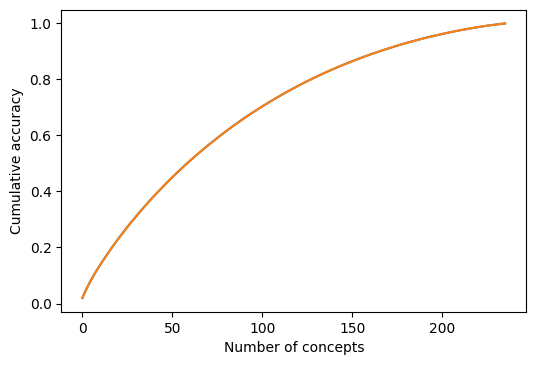

In [168]:
# Your code here.
PCA_1 = PCA(n_components = 236)
X_1 = PCA_1.fit_transform(TfIDF_train)

# print(PCA_1.explained_variance_ratio_.sum())
DF = (pd.DataFrame({'Component':[i for i in range(1,237)],
                    'Explained_var': PCA_1.explained_variance_ratio_.round(6)}).set_index('Component'))

print(DF)
# Make the plot
Cum_variance = []
acc_variance = 0
for j in range(1,237):
    acc_variance += DF.Explained_var[j]  
    Cum_variance.append(acc_variance)

    
fig, ax = plt.subplots(dpi = 100)    
plt.plot(Cum_variance)
# plt.plot(np.cumsum(PCA_1.explained_variance_ratio_))
ax.set_xlabel('Number of concepts')
ax.set_ylabel('Cumulative accuracy')
plt.show()
    

In [170]:
# To get the exact index where the variance is above 75%
for j in range(len(Cum_variance)):
    if Cum_variance[j] > 0.75:
        print(f'The min number of concepts to correctly explain at least 75% of data is: {j} ')
        break
        
np.argwhere(np.cumsum(PCA_1.explained_variance_ratio_)>0.75).min()



The min number of concepts to correctly explain at least 75% of data is: 113 


113

**Written answer: **

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [180]:
# Get words per component

TfIDFTransformer.get_feature_names()[0:3]

['10', 'absolutely', 'acting']

In [175]:
## Component 1 "10 " => label : "rating"
index_max_comp1 = np.array((sorted( ((x,i) for (i,x) in enumerate(TfIDF_train[:,0])), reverse=True )[:10]))
index_1 = (index_max_comp1[:,[1]].ravel()).astype(int)
print(index_1)
for j in index_1:
    print(x_train.iloc[j])
    print('\n')


[340 265 492 631 252 305 347 105 272 496]
Rating "10/10" Master pieceSome years ago, i heard Spielberg comment that he would redo the movie here and there if he had a chance. Well, Mr Spielberg, i guess nothing is perfect, but this movie - together with schindler's List - is your best. Even Oprah acts well in this one !What got me most is the realism of the story and drama. Stuff like this happened and is still happening in the world.'


After being hugely entertained by Mr. Brosnan's performance as a cad in "The Tailor of Panama" (which I rate 10/10 across the board: casting, acting, script, story, editing, pace, music, emotional impact, etc.), I enthusiastically anticipated this film. I was hugely disappointed. It is a script reading not a film, vulgar for the sake of being vulgar, bankrupt in every way that "The Tailor of Panama" is rich and satisfying. Blame it on the screen writing and directing. I sat in the theater waiting for the "good part;" it never came. I neither laughed no

In [176]:
# Concept 2 "absolutely" => "overal movie overview"
index_max_comp2 = np.array((sorted( ((x,i) for (i,x) in enumerate(TfIDF_train[:,1])), reverse=True )[:10]))
index_2 = (index_max_comp2[:,[1]].ravel()).astype(int)
print(index_2)
for j in index_2:
#     print(TfIDF_train[j,0])
    print(x_train.iloc[j])
    print('\n')

[673 107 663   6  38 120 380 468 561 133]
Just a stilted rip-off of the infinitely better "Murder, She Wrote", it is absolutely amazing that this poorly-written garbage lasted for a full eight years. I'm sure most of the people who watched this unentertaining crap were in their sixties and seventies and just tuned in because they had nothing better to do, or simply remembered its star from the old Dick Van Dyke Show. Van Dyke, who only had a decent career in the 1960s, never was much of an actor at all (by his own admission) and he was already far too old to play a doctor when the series began in 1993. He looks absolutely ancient as a result of years of chain smoking and heavy drinking. His talentless real life son Barry, a wooden actor who has rarely been in anything that didn't involve his father, plays his son in the series.'


It's very simple to qualify that movie: "A PURE MASTERPIECE". This opinion is formulated for the following reasons: the performance of the actors, they seem 

In [177]:
# Concept 3 concept :"acting" => 
index_max_comp3 = np.array((sorted( ((x,i) for (i,x) in enumerate(TfIDF_train[:,2])), reverse=True )[:10]))
index_3 = (index_max_comp3[:,[1]].ravel()).astype(int)
print(index_3)
for j in index_3:
#     print(TfIDF_train[j,0])
    print(x_train.iloc[j])
    print('\n')

[436 443 421 407 406 554 142 521 223 217]
Wow. This is really not that good. I would like to agree with the others in that at least the acting is good... it is, but it is nothing special.The movie is so precictable and i for one am sick of receiving culture info through movies.*/****'


Yes, indeed, it could have been a good movie. A love biangle, (sorry for the poetical license, but is not a triangle!) an interesting story, unfortunately badly told. The image is sometimes weird, sometimes OK, the picture looks crowded and narrow-sighted. The sound needs more attention (it usually does in Romanian movies), the light and color filters are sometimes badly chosen. The soundtrack is short and is not helping the action. About the acting... sorry but the best actress is the landlady. The others are acting immaturely and cannot convince the viewer. The acting is poetical when it should be realistic, and realistic when it should be poetical. It's a picture for adults, told by the children. Bot

**Written answer: **

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

Text(0.5, 1.0, 'Two first components in the test dataset')

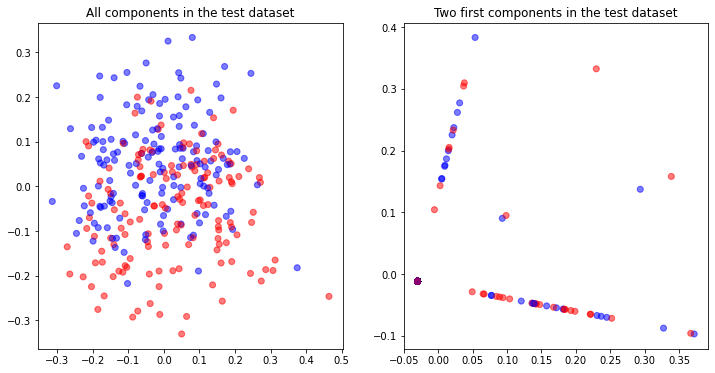

In [369]:
# Apply the test data
PCA_2 = PCA(n_components = 2)

Z_test_Total = PCA_2.fit_transform(TfIDF_test)

Z_test = PCA_2.fit_transform(TfIDF_test[:,0:2])

# Plot the two different set of points filtering by label.

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

color = np.array(['b' for x in range(300)])
color[y_test.values == 0] = 'r'

ax1.scatter(Z_test_Total[:,0], Z_test_Total[:,1] ,color = color, alpha = 0.3)
ax1.scatter(Z_test_Total[:,0], Z_test_Total[:,1], color = color, alpha = 0.3)
ax1.set_title('All components in the test dataset')


ax2.scatter(Z_test[:,0], Z_test[:,1] ,color = color, alpha = 0.3)
ax2.scatter(Z_test[:,0], Z_test[:,1], color = color, alpha = 0.3)
ax2.set_title('Two first components in the test dataset')


**Written answer:** 
Because it was not clear to me if I should use whole the test dataset or just the first two components, I considered both of the cases, on left and right graphs respectively. 

On the left graph, we can see the red dots which are corresponding to negative view, are mostly on the lower than the blue dots. But we have a big region filled with both red and blue dots, which means the model was not much successful in separating two groups. 

On the right graph that we are just looking at the first two components of the data, we have more red dots on the almost horizontal axis and more blue dots on the almost vertical axis, but still no perfect separation is seen.

I don't think this model is suitable for discriminating positive and negative cases.

## Task 2: Autoencoders [35 pts]

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer as shown in lab 10.2, to be trained over the original TfIDF train dataset. Use a total of 5 fully connected layers going from 236 to 100 to 60 to 100 to 236 units. Use a relu non-linearity for each of them. Then try at two more variations of this network. You could vary the number of hidden units, number of layers, or the type of nonlinearity that you are using. Train the models, each time reducing model reconstruction error. For each model you train, plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: Which of your models performs the best? After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?** [10 pts each architecture plus 5 pts arguing which one is better plus the explaining of overfitting]

In [326]:
# Model architecture and definition
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            nn.ReLU(inplace =True),
            nn.Linear(100,60),
            nn.ReLU(inplace =True),
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(inplace =True),
            nn.Linear(100,236),
            nn.ReLU(inplace =True),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [327]:
# Train! #build model
auto_enc = autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
Xtrain_scaled = torch.from_numpy(TfIDF_train.astype(np.float32))
Xtest_scaled = torch.from_numpy(TfIDF_test.astype(np.float32))

Train_loss = []
Test_loss = []
# #train model
for t in range (5000):
    y_pred = auto_enc(Xtrain_scaled)
    loss = loss_fn(y_pred, Xtrain_scaled)         # what we get from autoencoder is X^
    if t % 100 == 99:
        Train_loss.append(loss.item())
    auto_enc.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 
        if t % 100 == 99:
            ytest_pred = auto_enc(Xtest_scaled)
            loss = loss_fn(ytest_pred, Xtest_scaled)
            Test_loss.append(loss.item())

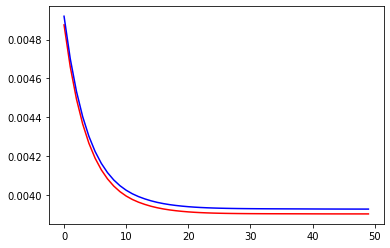

In [328]:
# Plot errors
# x = np.arange(5000)
# x.sha"pe
plt.plot(Test_loss, 'r')
plt.plot(Train_loss, 'b')
# plt.xticks(np.arange(0,50,10))

**Written answer:**

## Task 3: Benchmarking predictive capabilities of the compressed data. [30 pts]

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression) to predict the positive / negative class label for each movie. Calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

0.859


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.8589663760896638


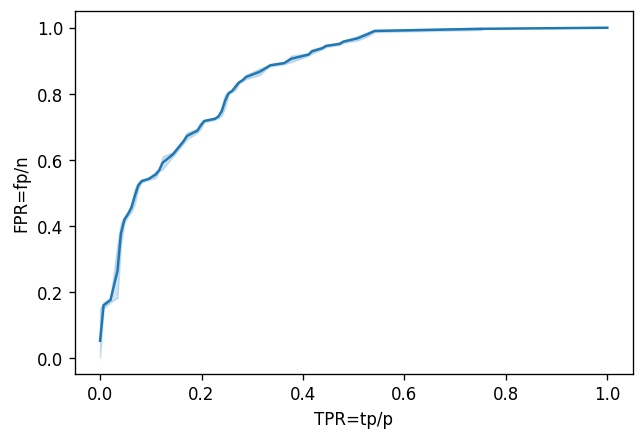

In [345]:
# Full dataset regression and AUC plot / calculation

model = LogisticRegressionCV(cv =5, max_iter = 1000000, multi_class='auto')

M1 = model.fit(TfIDF_train, y_train.values.ravel())

y_pred = M1.predict(TfIDF_test)
y_probs = M1.predict_proba(TfIDF_test)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)
print(auroc)
fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')
print(auc(fpr_t, tpr_t))

0.83


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.8298345490126312


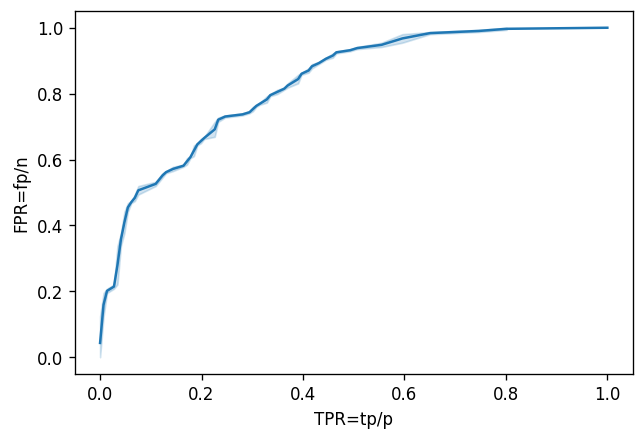

In [354]:
# PCA dataset regression and AUC plot / calculation

PCA_3 = PCA(n_components = 60)

Z3_train = PCA_3.fit_transform(TfIDF_train)
Z3_test = PCA_3.transform(TfIDF_test)


model = LogisticRegressionCV(cv =5, max_iter = 1000000, multi_class='auto')


M2 = model.fit(Z3_train, y_train.values.ravel())

y_pred = M2.predict(Z3_test)
y_probs = M2.predict_proba(Z3_test)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)
print(auroc)
fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')
print(auc(fpr_t, tpr_t))

0.613


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.6129247464863904


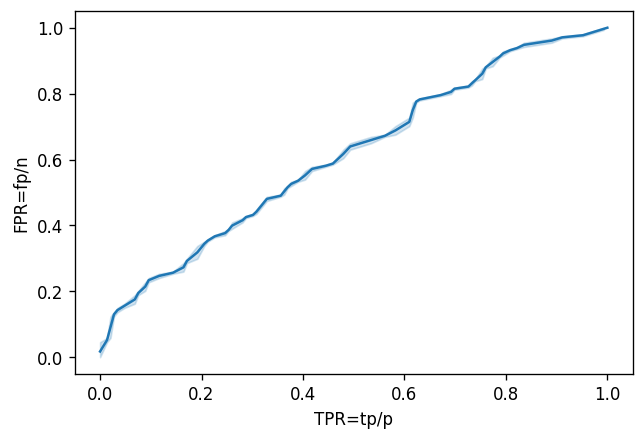

In [352]:
# Autoencoder dataset regression and AUC plot / calculation
Z4_train = auto_enc.encoder(Xtrain_scaled).detach().numpy()
Z4_test = auto_enc.encoder(Xtest_scaled).detach().numpy()

model = LogisticRegressionCV(cv =5, max_iter = 1000000, multi_class='auto')


M3 = model.fit(Z4_train, y_train.values.ravel())

y_pred = M3.predict(Z4_test)
y_probs = M3.predict_proba(Z4_test)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)
print(auroc)
fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')
print(auc(fpr_t, tpr_t))

**Written answer:**